# Analyzing Legislative Burden Upon Businesses Using NLP and ML

## Background

- Collaboration between Bardess and Government of Ontario
- Leverage NLP techniques to analyse patterns in the law that can be used to better understand it, extract information that is relevant to the public, create links with other legal and non legal documents


#### Focus for this workshop:

- Analyse the [Accessibility for Ontarians with Disability Act (AODA)](https://www.ontario.ca/laws/statute/05a11#BK11) and its [regulation](https://www.ontario.ca/laws/regulation/110191/v5):
    - Passed in 2005
    - Process for developing and enforcing accessibility standards in Ontario
- Identify and analyse burdens imposed upon businesses and government
    - A burden is a requirement or obligation that organizations have to comply with.
    - Physical, architectural, reporting, training etc.
    
<!--
trainig requirements: section 16 on regulation
ramps: 80.13 of regulations
-->


### https://github.com/bardess/odsc_2019_workshop

## Spacy

- [spacy.io](https://spacy.io/)
- Written in Python and Cython
- Pre-trained neural networks models for English, German, Spanish, Portuguese, French, Italian and Dutch
- Multi-language models

### Comparison with nltk
- Performance and production focused VS teaching and research
- Less functionalities
- Faster

Full comparison and details on accuracy and speed [here](https://spacy.io/usage/facts-figures#other-libraries)

### Functionalities

- Sentence and word tokenization
- Lemmatization
- Named Entity Recognition (NER)
- Parts Of Speech (POS) tagging
- Sependencing Parsing (DP)

### Usage

In [1]:
import spacy
from spacy import displacy

In [2]:
nlp = spacy.load('en')

In [3]:
parsed = nlp('''The ramp must have a minimum clear width of 900 mm''')

#### Tokenization, Normalization, Lemmatization
* Sentence and word tokenization

In [4]:
list(parsed.sents)

[The ramp must have a minimum clear width of 900 mm]

In [5]:
for token in parsed:
    print('"{0}"'.format(token.text), token.norm_, token.lemma_, token.is_stop, token.is_alpha)

"The" the the False True
"ramp" ramp ramp False True
"must" must must True True
"have" have have True True
"a" gonna a True True
"minimum" minimum minimum False True
"clear" clear clear False True
"width" width width False True
"of" of of True True
"900" 900 900 False False
"mm" mm mm False True


#### Named Entity Recognition (NER)
* Locate and classify named entity mentions in unstructured text into pre-defined categories such as the person names, organizations, locations, dates etc.

In [6]:
parsed.ents

(900,)

In [7]:
displacy.render(parsed, style='ent', jupyter=True)

#### Parts of Speech Taggings and Dependency Parsing

* Parts Of Speech tagging: assign words with similar grammatical properties to the same tag/category
* Dependencing Parsing: builds a tree representing the grammatical relashionships between words in the sentence

In [8]:
#parsed = nlp('Every obligated organization that is a library board shall provide access to or arrange for the provision of access to accessible materials where they exist.')

In [9]:
for token in parsed:
    print('"{}"'.format(token.text), token.pos_, token.dep_)

"The" DET det
"ramp" NOUN nsubj
"must" VERB aux
"have" VERB ROOT
"a" DET det
"minimum" ADJ amod
"clear" ADJ amod
"width" NOUN dobj
"of" ADP prep
"900" NUM nummod
"mm" NOUN pobj


In [10]:
displacy.render(parsed, style='dep', jupyter=True)

### A little grammar

`subject`: 
- The word or phrase that indicates "who" or "what" performs the action
- Entities that are responsible for complying with the burdens/obligations

**Every employer** shall provide individualized workplace emergency response information to employees who have a disability

`object`:
- The entity that is acted upon by the subject
- The burden specification

Every employer shall **provide individualized workplace emergency response information** to employees who have a disability

## Identifying Burdens

- The structure of legal texts is relatively rigid and the lexicon is limited
- Rule based extraction based on a lightweight ontology

In [11]:
BURDENS = ['shall', 'must', 'ought', 'oblige', 'require']

**WordNet®** is a large lexical database of English. Nouns, verbs, adjectives and adverbs are grouped into sets of cognitive synonyms (synsets), each expressing a distinct concept. Synsets are interlinked by means of conceptual-semantic and lexical relations. The resulting network of meaningfully related words and concepts can be navigated with the [browser](http://wordnetweb.princeton.edu/perl/webwn). WordNet is also freely and publicly available for download.

In [12]:
from nltk.corpus import wordnet

In [13]:
wordnet.synsets('require')

[Synset('necessitate.v.01'),
 Synset('ask.v.04'),
 Synset('command.v.02'),
 Synset('want.v.02')]

In [14]:
synonyms = []

for w in BURDENS:
    for syn in wordnet.synsets(w, pos='v'):
        for l in syn.lemmas():
            synonyms.append(l.name())

In [15]:
print(synonyms)

['compel', 'oblige', 'obligate', 'oblige', 'bind', 'hold', 'obligate', 'oblige', 'accommodate', 'necessitate', 'ask', 'postulate', 'need', 'require', 'take', 'involve', 'call_for', 'demand', 'ask', 'require', 'expect', 'command', 'require', 'want', 'need', 'require']


The list of verbs in `BURDENS` and `synonyms` define a lightweight ontology, that is used to idenlify the obligations prescribed by AODA. Given a sentence:
- Extract lemma from each term
- If any of the lemmas appears in the ontology, add the sentence to the list of burdens

In [16]:
import numpy as np
import pandas as pd

In [17]:
aoda = pd.read_csv('../data/sents_and_titles_w_labels.csv')

In [18]:
aoda[['index','Title', 'section', 'text']].head()

,index,Title,section,text
0,0,INTERPRETATION,AODA Purpose,Recognizing the history of discrimination agai...
1,1,INTERPRETATION,AODA Definitions,"In this Act, “accessibility standard” means an..."
2,2,INTERPRETATION,AODA Definitions,”) “barrier” means anything that prevents a pe...
3,3,INTERPRETATION,AODA Definitions,"(“directeur”) “disability” means, any degree o..."
4,4,INTERPRETATION,AODA Definitions,“Minister” means the Minister of Citizenship a...


In [19]:
aoda['tagged_as_burden'] = aoda.text\
    .map(lambda sent: any([True for token in nlp(sent) if token.lemma_ in BURDENS + synonyms]))

### Evaluation

In [20]:
aoda['tagged_as_burden'].sum()

543

* Accuracy

In [21]:
(aoda.is_burden == aoda.tagged_as_burden.astype(int)).sum()/len(aoda)

0.8909090909090909

In [22]:
TP = ((aoda.is_burden == 1) & (aoda.tagged_as_burden == True)).sum()
FP = ((aoda.is_burden == 0) & (aoda.tagged_as_burden == True)).sum()
FN = ((aoda.is_burden == 1) & (aoda.tagged_as_burden == False)).sum()

* Precision: \$\frac{TP}{TP + FP}$


<img src=img/precision.png width=200 align='left'/>

In [23]:
TP / (TP + FP)

0.7661141804788214

In [24]:
aoda[((aoda.is_burden == 0) & (aoda.tagged_as_burden == True))].head()

,index,section,text,is_burden,Title,tagged_as_burden
3,3,AODA Definitions,"(“directeur”) “disability” means, any degree o...",0,INTERPRETATION,True
4,4,AODA Definitions,“Minister” means the Minister of Citizenship a...,0,INTERPRETATION,True
13,13,AODA Crown bound,This Act binds the Crown.,0,APPLICATION,True
17,17,AODA Application of standards,An accessibility standard shall name or descri...,0,ACCESSIBILITY STANDARDS,True
36,36,AODA Consultation with ministries,Before establishing a standards development co...,0,ACCESSIBILITY STANDARDS,True


In [25]:
aoda.iloc[17]['text']

'An accessibility standard shall name or describe the persons or organizations to which it applies.'

Recall: \$\frac{TP}{TP + FN}$


<img src=img/recall.png width=200 align='left'/>

In [26]:
TP / (TP + FN)

0.9742388758782201

In [27]:
aoda[((aoda.is_burden == 1) & (aoda.tagged_as_burden == False))]

,index,section,text,is_burden,Title,tagged_as_burden
33,33,AODA Process for development of standards,The Minister is responsible for establishing a...,1,ACCESSIBILITY STANDARDS,False
171,171,AODA Accessibility Directorate of Ontario,The directorate known in English as the Access...,1,ADMINISTRATION,False
422,365,REG Educational and training resources and mat...,Provide student records and information on pro...,1,INFORMATION AND COMMUNICATIONS STANDARDS,False
612,552,REG Courtesy seating,": On July 1, 2016, subsection 49 of the Regul...",1,TRANSPORTATION STANDARDS,False
741,680,REG Steps,The steps have surfaces that are slip resistan...,1,TRANSPORTATION STANDARDS,False
742,681,REG Steps,"The steps have uniform, closed riser heights a...",1,TRANSPORTATION STANDARDS,False
987,920,"REG Exceptions, general",It is not practicable to comply with the requi...,1,DESIGN OF PUBLIC SPACES STANDARDS (ACCESSIBILI...,False
988,920,"REG Exceptions, general",It is not practicable to comply with the requi...,1,DESIGN OF PUBLIC SPACES STANDARDS (ACCESSIBILI...,False
1059,990,"REG Exterior paths of travel, depressed curbs",” means a seamless gradual slope at transition...,1,DESIGN OF PUBLIC SPACES STANDARDS (ACCESSIBILI...,False
1095,1026,REG Types of accessible parking spaces,"Type B, a standard parking space which has a m...",1,DESIGN OF PUBLIC SPACES STANDARDS (ACCESSIBILI...,False


In [28]:
aoda.iloc[33]['text']

'The Minister is responsible for establishing and overseeing a process to develop and implement all accessibility standards necessary to achieving the purposes of this Act.'

## Identify the subjects of the burdens

**Objective**

- Extract the subjects of the burdens
- Organize burdens into homogeneous groups based on the entities they affect, e.g. public VS private

Dependency parsing tags for sentence subjects: `nsubj`, `nsubjpass`, `csubj`, `csubjpass`, `agent`, `expl`

In [29]:
parsed = nlp('''Obligated organizations that are school boards or educational or training institutions shall keep a record of the training provided.''')

**Obligated organizations that are school boards or educational or training institutions** shall keep a record of the training provided

Obligated **organizations** that are school boards or educational or training institutions shall keep a record of the training provided.

In [30]:
displacy.render(parsed, style='dep', jupyter=True)

#### Solution

- Combine tags assigned by the Dependency Parser with Breadth First Search
- Navigate the dependency tree and identify the subset of token that are related to the subject by a parent-child relationship

In [31]:
from utils import make_sentence, STOPWORDS

In [32]:
aoda.columns

Index(['index', 'section', 'text', 'is_burden', 'Title', 'tagged_as_burden'], dtype='object')

In [33]:
df = pd.DataFrame(
        list(
            aoda[aoda.tagged_as_burden][['index', 'section', 'text', 'Title']]\
                .apply(lambda row: make_sentence(row['index'], nlp(row['text']), row['section'], row['Title']),
                       axis=1)
    )
)

In [34]:
df.head(1)

,sid,section,title,text,subj,v,obj
0,3,AODA Definitions,INTERPRETATION,"(“directeur”) “disability” means, any degree o...",( “ directeur ” ) “ disability ” that by bodil...,[],the generality of the foregoing diabetes melli...


- Normalize
- Project subjects into a semantic space ([GloVe](https://nlp.stanford.edu/projects/glove/))
- Reduce dimensionality
- KMeans clustering

* Normalization

In [35]:
df['s_norm'] = df.subj.apply(
    lambda subj: [t.lemma_ for t in nlp(subj) if t.is_alpha and t.lemma_ not in STOPWORDS]
)

* Projection into GloVe space

In [36]:
glove50 = spacy.load('/tmp/vectors')

In [37]:
def glove_projection(tokens):
    vectors = [glove50(token).vector for token in tokens]
    return np.mean(vectors, axis=0) if tokens else np.zeros(50)

In [38]:
df = pd.concat([
    df,
    pd.DataFrame(df.s_norm.map(glove_projection).tolist(),
                 columns=['s{}'.format(i) for i in range(50)])
], axis=1)

In [39]:
df.head(1)

,sid,section,title,text,subj,v,obj,s_norm,s0,s1,...,s40,s41,s42,s43,s44,s45,s46,s47,s48,s49
0,3,AODA Definitions,INTERPRETATION,"(“directeur”) “disability” means, any degree o...",( “ directeur ” ) “ disability ” that by bodil...,[],the generality of the foregoing diabetes melli...,"[directeur, disability, bodily, injury, benefit]",0.262835,0.235594,...,-0.016954,-0.317374,-0.123995,0.770236,-0.090187,-0.600568,-0.100497,0.311346,0.577616,0.208082


### Dimensionality Reduction (Spectral Embeddings)

- Non linear embeddings
- Laplacian Eigenmaps: find a low dimensional representation of the data using a spectral decomposition of the Graph Laplacian
- Points that are close to each other on the manifold are mapped close to each other in the low dimensional space
- Local distances are preserved

In [40]:
from sklearn.cluster import KMeans
from sklearn.manifold import SpectralEmbedding

In [41]:
n_dim = 2
embeddings = SpectralEmbedding(n_components=n_dim)

In [42]:
subjects = pd.DataFrame(
    embeddings.fit_transform(df[['s{}'.format(i) for i in range(50)]]),
    columns=['x{}'.format(i) for i in range(n_dim)])

### KMeans

In [43]:
inertia = []
for k in range(1, 10):
    km = KMeans(n_clusters=k).fit(subjects)
    inertia.append(km.inertia_)

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt

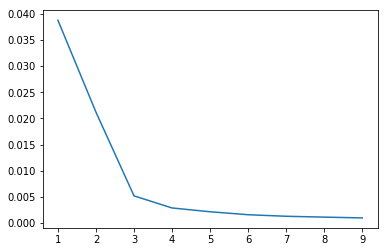

In [45]:
sns.lineplot(x=range(1, 10), y=inertia)

In [46]:
km = KMeans(n_clusters=3, random_state=0).fit(subjects)

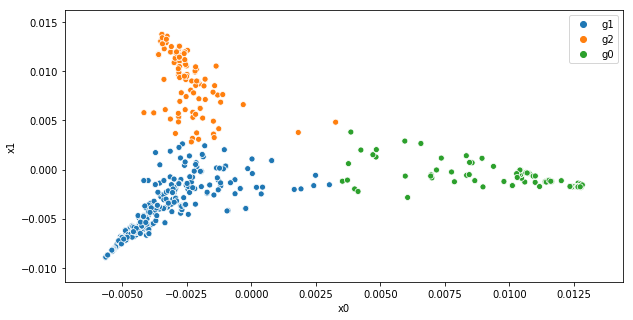

In [47]:
plt.figure(figsize=(10,5))
sns.scatterplot(data=subjects, x='x0', y='x1', hue=['g{}'.format(label) for label in km.labels_])

### Visualizing the Groups

- Distribution of word frequencies in the groups

In [48]:
from utils import LemmaTokenizer, vocab_barplot

In [49]:
from utils import LemmaTokenizer, vocab_barplot
from sklearn.feature_extraction.text import CountVectorizer

In [50]:
counter = CountVectorizer(tokenizer=LemmaTokenizer())
counter.fit(df.subj)

# transform sentences using CountVectorizer
subj = pd.DataFrame(
    counter.fit_transform(df['subj'].astype(str)).toarray(),
    columns=counter.get_feature_names()
)

# add groups labels
subj['label'] = km.labels_

# aggregate frequences at group level
groups = pd.melt(
    subj.groupby('label').sum().reset_index(),
    id_vars='label', var_name='word', value_name='count'
).groupby('label').apply(lambda group: group.sort_values(by='count', ascending=False)).reset_index(drop=True)

# rank by frequency
groups['rank'] = groups.groupby('label')['count'].rank(method='first', ascending=False)

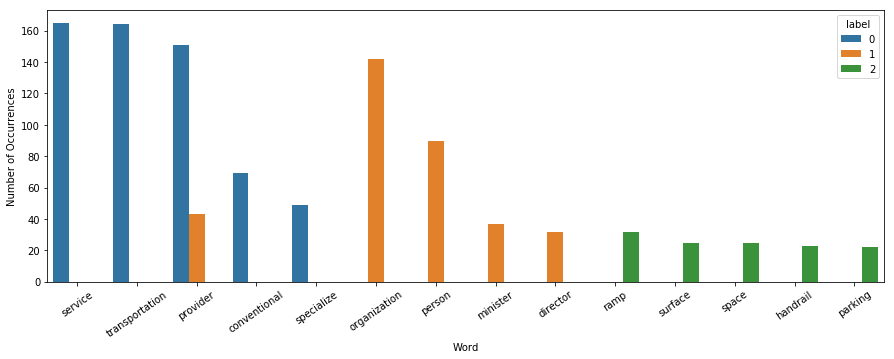

In [51]:
plt.figure(figsize=(15,5))
sns.barplot(data=groups[groups['rank'] <= 5], x='word', y='count', hue='label')
plt.xticks(rotation=35)
plt.xlabel('Word')
plt.ylabel('Number of Occurrences')
plt.show();

### Group 0

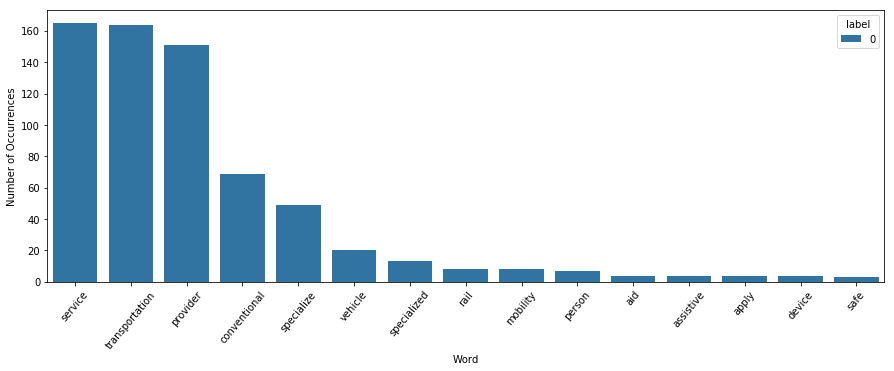

In [52]:
vocab_barplot(groups, label=0, max_rank=15)

In [53]:
(km.labels_ == 0).sum() / len(km.labels_)

0.21178637200736647

In [54]:
pd.DataFrame(df[km.labels_ == 0]['title'].value_counts() / (km.labels_ == 0).sum())

,title
TRANSPORTATION STANDARDS,0.921739
DESIGN OF PUBLIC SPACES STANDARDS (ACCESSIBILITY STANDARDS FOR THE BUILT ENVIRONMENT),0.069565
GENERAL,0.008696


### Group 1

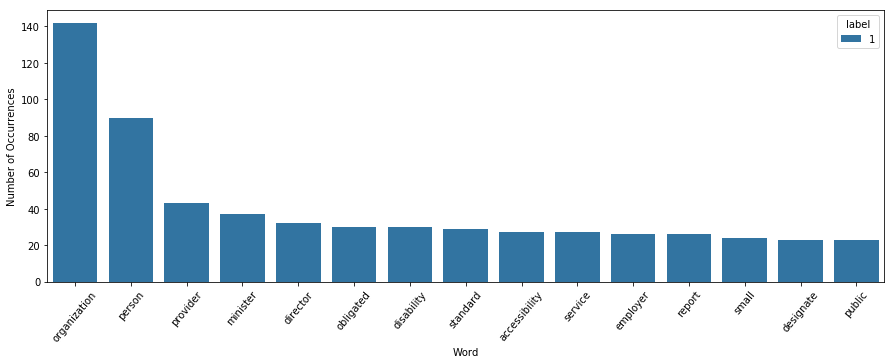

In [55]:
vocab_barplot(groups, label=1, max_rank=15)

In [56]:
(km.labels_ == 1).sum() / len(km.labels_)

0.5340699815837937

In [57]:
pd.DataFrame(df[km.labels_ == 1]['title'].value_counts() / (km.labels_ == 1).sum())

,title
DESIGN OF PUBLIC SPACES STANDARDS (ACCESSIBILITY STANDARDS FOR THE BUILT ENVIRONMENT),0.206897
GENERAL,0.131034
TRANSPORTATION STANDARDS,0.124138
INFORMATION AND COMMUNICATIONS STANDARDS,0.117241
ACCESSIBILITY STANDARDS,0.093103
EMPLOYMENT STANDARDS,0.082759
COMPLIANCE,0.068966
INSPECTIONS,0.041379
DIRECTOR’S ORDERS AND ADMINISTRATIVE PENALTIES,0.037931
APPEALS TO TRIBUNAL,0.031034


### Group 2

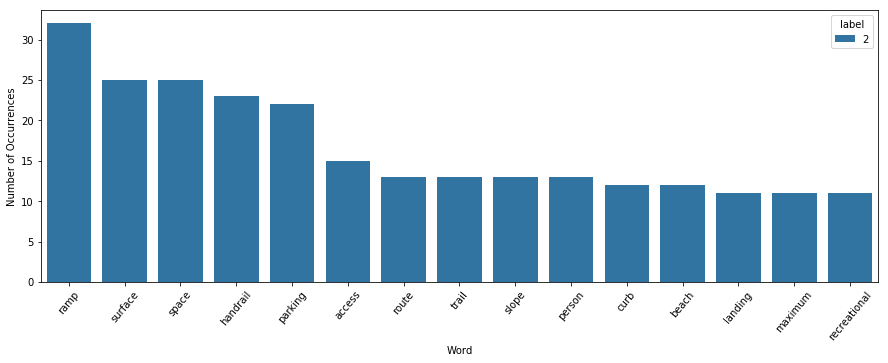

In [58]:
vocab_barplot(groups, label=2, max_rank=15)

In [59]:
(km.labels_ == 2).sum() / len(km.labels_)

0.2541436464088398

In [60]:
pd.DataFrame(df[km.labels_ == 2]['title'].value_counts() / (km.labels_ == 2).sum())

,title
DESIGN OF PUBLIC SPACES STANDARDS (ACCESSIBILITY STANDARDS FOR THE BUILT ENVIRONMENT),0.804348
TRANSPORTATION STANDARDS,0.137681
ACCESSIBILITY STANDARDS,0.014493
COMPLIANCE,0.014493
DIRECTOR’S ORDERS AND ADMINISTRATIVE PENALTIES,0.014493
ADMINISTRATION,0.007246
EMPLOYMENT STANDARDS,0.007246


### Conclusions

- AODA has a significant section dedicated to transportation services
- Many references to architectural and physical requirements
- Hard to split beween responsibilities that fall on the Governement and its agencies and responsibilities that fall on businesses

## Topic Analysis

- Latent Dirichlet Allocation
- Generative probabilistic model that explains how the words have been assigned to documents/sentences
- Latent variables explain regularieties in the text (topics)

In [61]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import LatentDirichletAllocation

In [62]:
n_topics = 3

pipeline = Pipeline([
    ('counts', CountVectorizer(max_features=50, tokenizer=LemmaTokenizer())),
    ('lda', LatentDirichletAllocation(n_components=n_topics, learning_decay=0.5, max_iter=10, random_state=1))
])

In [63]:
pipeline.fit(df.subj)

Pipeline(memory=None,
     steps=[('counts', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=50, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...           random_state=1, topic_word_prior=None,
             total_samples=1000000.0, verbose=0))])

In [64]:
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

In [65]:
vectorizer = pipeline.named_steps['counts']
dtm = vectorizer.fit_transform(df.subj)

In [ ]:
p = pyLDAvis.sklearn.prepare(pipeline.named_steps['lda'], dtm, vectorizer)
pyLDAvis.display(p)

Similar results as the previous approach but with less clear distinction bewteen the groups

### Follow up

- Preprocessing, e.g. extend the list of stopwords to include words like organizations
- Analyse the objects of the sentences

### https://github.com/bardess/odsc_2019_workshop